In [26]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

In [27]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [28]:
import os
import sys

nb_dir_1 = os.path.split(os.getcwd())[0]
current_path = os.getcwd()
parent = os.path.dirname(current_path)
nb_dir_2 = os.path.split(parent)[0]

if nb_dir_1 not in sys.path:
    sys.path.append(nb_dir_1)

if nb_dir_2 not in sys.path:
    sys.path.append(nb_dir_2)

In [29]:
import numpy as np
import pandas as pd
import torch
from core.models import LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import scipy.stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from core.data_preparation import DataPreparation
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

In [30]:
# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [31]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [32]:
filepath = "../Data/JPM_Stock_Close.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2003-01-02,25.440001
1,2003-01-03,25.940001
2,2003-01-06,27.980000
3,2003-01-07,27.840000
4,2003-01-08,26.770000


In [33]:
data.tail()

,date,close
4798,2022-01-24,144.949997
4799,2022-01-25,146.529999
4800,2022-01-26,147.919998
4801,2022-01-27,145.309998
4802,2022-01-28,146.610001


In [34]:
data['close'].isnull().values.any()

False

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Closing price in USD')

In [36]:
TsAD = importr('otsad')
TSdist = importr('TSdist')

In [37]:
train_len = 0.8*len(data)

In [38]:
res = TsAD.OcpTsSdEwma(data['close'].values, train_len, 0.01, 3, 50 )

In [39]:
df = pd.DataFrame(res)

In [40]:
df.head()

,is.anomaly,lcl,ucl
0,0.0,25.440001,25.440001
1,0.0,25.940001,25.940001
2,0.0,27.980000,27.980000
3,0.0,27.840000,27.840000
4,0.0,26.770000,26.770000


In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='close price'))
fig.add_trace(go.Scatter(x=df.index, y=df['lcl'], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index, y=df['ucl'], mode='lines', name='upper control limit'))
# fig.add_trace(go.Scatter(x=df.index[2316:2416], y=preds, mode='lines', name='predictions'))


# fig.update_xaxes(range=["2009-11-01", "2021-11-01"])
# fig.update_yaxes(range=[500, 2500])

In [42]:
anomaly_indices = df[df['is.anomaly'] == 1.0].index

In [43]:
rows = data.iloc[anomaly_indices, :]

In [44]:
# rows

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='lines'))
fig.add_trace(go.Scatter(x=rows['date'], y=rows['close'], mode='markers', name='markers'))

# fig.update_xaxes(range=["2009-11-01", "2021-11-01"])
# fig.update_yaxes(range=[500, 2500])

In [46]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [47]:
train_set, test_set = prep.splitData(data['close'].values)

In [48]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (3822, 20, 1)
y_train.shape =  (3822, 1)
x_test.shape =  (941, 20, 1)
y_test.shape =  (941, 1)


In [49]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [50]:
torch.save(model, 'lstm_jpm.pt')

In [51]:
actual_test_len = len(test_set) - window_size

In [52]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

Test Score: 0.07 MAPE
R-squared value is 0.6643094769750558
RMSE:  13.72710607382741


In [53]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-actual_test_len:], y=y_test[:,0], mode='lines', name='actual close price'))
# fig.add_trace(go.Scatter(x=data.index[-len(test_set):], y=data['close'][-actual_test_len:], mode='lines', name='close price'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['lcl'][-actual_test_len:], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['ucl'][-actual_test_len:], mode='lines', name='upper control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y= y_test_pred[:,0], mode='lines', name='predicted close price'))


# fig.update_yaxes(range=[500, 2500])

#### Find distance between forecast distributions and actual test values using different distance measures from R

### Dynamic Time Warping

In [54]:
dtw_dist = []
test_set_range = []

for i in range(9):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(dtw.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "DTW distance" : dtw_dist

    }

df1 = pd.DataFrame(finalResult)

In [55]:
pdc_dist = []
test_set_range = []

for i in range(9):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  pdc = TSdist.PDCDistance(X1, X2)
  pdc_dist.append(pdc.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "PDC distance" : pdc_dist

    }

df2 = pd.DataFrame(finalResult)

In [56]:
cort_dist = []
test_set_range = []

for i in range(9):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  # print(X2.shape)

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  # print(type(X1))

  cort = TSdist.CortDistance(X1, X2, deltamethod="DTW")
  cort_dist.append(cort.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Temporal Correlation distance" : cort_dist

    }

df3 = pd.DataFrame(finalResult)

In [57]:
df3

,range,Temporal Correlation distance
0,0 : 100,116.954858
1,100 : 200,139.423586
2,200 : 300,125.884536
3,300 : 400,211.044727
4,400 : 500,829.925714
5,500 : 600,223.766717
6,600 : 700,424.251241
7,700 : 800,3313.493393
8,800 : 900,4724.945462


In [58]:
fourier_dist = []
test_set_range = []

for i in range(9):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  fourier = TSdist.FourierDistance(X1, X2)
  fourier_dist.append(fourier.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Fourier distance" : fourier_dist

    }

df4 = pd.DataFrame(finalResult)

In [59]:
df4

,range,Fourier distance
0,0 : 100,168.363066
1,100 : 200,266.529916
2,200 : 300,181.058387
3,300 : 400,367.024071
4,400 : 500,716.175854
5,500 : 600,305.848696
6,600 : 700,593.322020
7,700 : 800,2293.107242
8,800 : 900,2761.986456


#### KL divergence

In [60]:
def computeKLD(X1, X2, bins=5):

    # values_1, edges_1 = np.histogram(X1,bins=bins,density=True)
    # values_2, edges_2 = np.histogram(X2,bins=bins,density=True)

    values_1, edges_1 = np.histogram(X1,bins=bins)
    values_2, edges_2 = np.histogram(X2,bins=bins)
   
    #Consider only first std. deviation of original series i.e. P(x).    
    P = values_1
    Q = values_2
    delta_x = 2/bins
    res =  np.sum( P * np.log2( P/Q )) * delta_x
    return res

In [61]:
KLD = []
test_set_range = []

for i in range(9):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    kld_res = computeKLD(X1, X2)

    KLD.append(kld_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "KL divergence" : KLD

}

df5 = pd.DataFrame(finalResult)

#### Jensen Shannon Divergence

In [62]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    if len(p)>len(q):
        p = np.random.choice(p,len(q)) # random.choice make same length to p/q
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2

In [63]:
JSD = []
test_set_range = []

for i in range(9):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    jsd_res = jsd(X1, X2)

    JSD.append(jsd_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "JS divergence" : JSD

}

df6 = pd.DataFrame(finalResult)

In [64]:
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'],
 df4['Fourier distance'], df5['KL divergence'], df6['JS divergence']], axis=1)
result

,range,DTW distance,PDC distance,Temporal Correlation distance,Fourier distance,KL divergence,JS divergence
0,0 : 100,116.366982,1.322478,116.954858,168.363066,13.240576,0.000057
1,100 : 200,138.522903,0.738578,139.423586,266.529916,7.275403,0.000096
2,200 : 300,123.843010,1.183308,125.884536,181.058387,3.295118,0.000067
3,300 : 400,245.123146,1.195664,211.044727,367.024071,0.293123,0.000145
4,400 : 500,812.318008,0.953213,829.925714,716.175854,10.935441,0.000805
5,500 : 600,208.158203,1.217400,223.766717,305.848696,16.439860,0.000216
6,600 : 700,428.652634,1.356291,424.251241,593.322020,10.920889,0.000255
7,700 : 800,3377.709572,1.073209,3313.493393,2293.107242,54.081902,0.000089
8,800 : 900,3949.023712,0.724433,4724.945462,2761.986456,4.348859,0.000133


In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-len(x_test):], y=data['close'][-len(x_test):], mode='lines', name='closing price'))

# fig.update_xaxes(range=["2018-07-01", "2021-11-01"])
# fig.update_yaxes(range=[500, 2500])

In [66]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[:100], y=y_test[:100,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[:100], y= y_test_pred[:100,0], mode='lines', name='predicted close price'))


# fig.update_yaxes(range=[1000, 1500])

In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[100:200], y=y_test[100:200,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[100:200], y= y_test_pred[100:200,0], mode='lines', name='predicted close price'))


# fig.update_yaxes(range=[1000, 1500])

In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[200:300], y=y_test[200:300,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[200:300], y= y_test_pred[200:300,0], mode='lines', name='predicted close price'))


# fig.update_yaxes(range=[1000, 1500])

In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[300:400], y=y_test[300:400,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[300:400], y= y_test_pred[300:400,0], mode='lines', name='predicted close price'))

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[400:500], y=y_test[400:500,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[400:500], y= y_test_pred[400:500,0], mode='lines', name='predicted close price'))

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[800:900], y=y_test[800:900,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[800:900], y= y_test_pred[800:900,0], mode='lines', name='predicted close price'))

#### Measure how accuracy of model changes with shift in test set

In [72]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(9):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*100} : {(i+1)*100}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df = pd.DataFrame(accuracy)

In [73]:
acc_df

,range,RMSE,MAPE,R2-score
0,0 : 100,2.379004,1.720625,0.647592
1,100 : 200,3.373512,2.395647,0.572933
2,200 : 300,2.537162,1.895893,0.648220
3,300 : 400,4.668837,3.268656,0.676725
4,400 : 500,9.711670,7.326217,0.797256
5,500 : 600,4.214648,3.438655,0.302241
6,600 : 700,7.128945,4.320664,0.772652
7,700 : 800,23.129682,14.563511,-19.204953
8,800 : 900,27.885444,16.852862,-18.206742


In [74]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(13):
    
    X1, X2 = gt[i*70 : (i+1)*70], preds[i*70 : (i+1)*70]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*70} : {(i+1)*70}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df2 = pd.DataFrame(accuracy)

In [75]:
acc_df2

,range,RMSE,MAPE,R2-score
0,0 : 70,2.677125,2.067130,0.554657
1,70 : 140,2.587867,1.714341,0.530800
2,140 : 210,3.300669,2.302592,0.260863
3,210 : 280,2.800227,2.103286,0.592161
4,280 : 350,2.990300,2.126763,0.461073
5,350 : 420,7.510549,5.172770,0.145687
6,420 : 490,9.993718,7.765952,0.782782
7,490 : 560,4.746477,4.031329,0.307381
8,560 : 630,2.864396,2.352172,-0.165014
9,630 : 700,8.296850,5.172745,0.297276


In [76]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(18):
    
    X1, X2 = gt[i*50 : (i+1)*50], preds[i*50 : (i+1)*50]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*50} : {(i+1)*50}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df3 = pd.DataFrame(accuracy)

In [77]:
acc_df3

,range,RMSE,MAPE,R2-score
0,0 : 50,2.654169,2.024833,0.274675
1,50 : 100,2.067537,1.416416,-0.490708
2,100 : 150,3.220711,2.322087,-0.005453
3,150 : 200,3.519685,2.469206,-0.360330
4,200 : 250,2.872576,2.177740,0.658969
5,250 : 300,2.150045,1.614046,0.091554
6,300 : 350,3.347152,2.415429,0.462981
7,350 : 400,5.691454,4.121883,0.256144
8,400 : 450,9.837320,7.061023,-27.365790
9,450 : 500,9.584374,7.591411,0.581534


#### ECDF distance measures between actual values and forecasts

In [78]:
wasserstein_distance = []
test_set_range = []

for i in range(9):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Wasserstein_Dist(X1, X2)

    wasserstein_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Wasserstein distance" : wasserstein_distance

}

df7 = pd.DataFrame(finalResult)

In [79]:
KS_distance = []
test_set_range = []

for i in range(9):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Kolmogorov_Smirnov_Dist(X1, X2)

    KS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Kolmogorov Smirnov distance" : KS_distance

}

df8 = pd.DataFrame(finalResult)

In [80]:
DTS_distance = []
test_set_range = []

for i in range(9):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = DTS_Dist(X1, X2)

    DTS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "DTS distance" : DTS_distance

}

df9 = pd.DataFrame(finalResult)

In [81]:
result = pd.concat([df7, df8['Kolmogorov Smirnov distance'], df9['DTS distance']], axis=1)
result

,range,Wasserstein distance,Kolmogorov Smirnov distance,DTS distance
0,0 : 100,0.920164,0.14,0.228451
1,100 : 200,1.679154,0.19,0.351856
2,200 : 300,0.814356,0.14,0.221290
3,300 : 400,3.142296,0.31,0.660695
4,400 : 500,7.180750,0.53,1.317851
5,500 : 600,1.297244,0.20,0.335506
6,600 : 700,4.972737,0.28,1.040163
7,700 : 800,22.728028,1.00,3.519758
8,800 : 900,27.347673,1.00,4.111095


#### ECDF distance measures between train set and test set

In [82]:
dtw_dist = []
test_set_range = []

for i in range(13):

  X1, X2 = train_set, gt[i*70 : (i+1)*70]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(np.round(dtw.item(), 2))
  test_set_range.append(f'{i*70} : {(i+1)*70}')

finalResult_dtw = { "range" : test_set_range,    
    "DTW distance" : dtw_dist,

    }

df_dtw = pd.DataFrame(finalResult_dtw)

In [83]:
df_dtw

,range,DTW distance
0,0 : 70,210913.40
1,70 : 140,212360.27
2,140 : 210,168590.13
3,210 : 280,192650.25
4,280 : 350,217252.00
5,350 : 420,242134.81
6,420 : 490,126133.80
7,490 : 560,139279.58
8,560 : 630,172036.42
9,630 : 700,197769.30


In [84]:
def get_statistical_dist_measures(X_train, X_test):   

    CVM_distance = Cramer_Von_Mises_Dist(X_train, X_test)
    Anderson_Darling_distance = Anderson_Darling_Dist(X_train, X_test)
    Kolmogorov_Smirnov_distance = Kolmogorov_Smirnov_Dist(X_train, X_test)
    Kuiper_distance = Kuiper_Dist(X_train, X_test)
    Wasserstein_distance = Wasserstein_Dist(X_train, X_test)
    DTS_distance = DTS_Dist(X_train, X_test)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [85]:
test_set_range = []
finalResult = []

for i in range(9):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [86]:
test_set_range = []
finalResult2 = []

for i in range(13):
    
    X1, X2 = train_set, gt[i*70 : (i+1)*70]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult2.append(distances)
    test_set_range.append(f'{i*70} : {(i+1)*70}')



In [87]:
df = pd.DataFrame(finalResult)
# df.insert(0, 'Test set range', test_set_range)
frames = [acc_df[['RMSE',  'R2-score', 'MAPE']], df]
df = pd.concat(frames, axis=1)
df

#As distance between train and test increases, model's performance decreases. We should analyse this point here.
# Only DTS_dist and Wasserstein_dist are positively correlated to model's accuracy.

,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,2.379004,0.647592,1.720625,62.454292,1380.971661,3.530827,0.977095,0.977095,62.600737
1,3.373512,0.572933,2.395647,58.353669,1343.318912,2.971255,0.958095,0.961999,55.967425
2,2.537162,0.648220,1.895893,60.322758,1363.164951,3.254719,0.973451,0.975794,59.589261
3,4.668837,0.676725,3.268656,64.949768,1399.617277,4.489656,0.978397,0.978397,69.293000
4,9.711670,0.797256,7.326217,61.236890,1349.484774,4.806970,0.911244,0.911244,68.631401
5,4.214648,0.302241,3.438655,54.514181,1298.733696,2.369452,0.916450,0.925039,48.321203
6,7.128945,0.772652,4.320664,63.695917,1383.621869,4.739991,0.959396,0.959396,68.486600
7,23.129682,-19.204953,14.563511,66.731467,1418.017319,8.083479,1.000000,1.000000,105.977400
8,27.885444,-18.206742,16.852862,66.860340,1419.367319,8.697911,1.000000,1.000000,111.936200


In [88]:
res = pd.concat([acc_df[['RMSE',  'R2-score', 'MAPE']], df[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist
0,2.379004,0.647592,1.720625,3.530827,62.600737,1380.971661
1,3.373512,0.572933,2.395647,2.971255,55.967425,1343.318912
2,2.537162,0.648220,1.895893,3.254719,59.589261,1363.164951
3,4.668837,0.676725,3.268656,4.489656,69.293000,1399.617277
4,9.711670,0.797256,7.326217,4.806970,68.631401,1349.484774
5,4.214648,0.302241,3.438655,2.369452,48.321203,1298.733696
6,7.128945,0.772652,4.320664,4.739991,68.486600,1383.621869
7,23.129682,-19.204953,14.563511,8.083479,105.977400,1418.017319
8,27.885444,-18.206742,16.852862,8.697911,111.936200,1419.367319


In [89]:
df1 = pd.DataFrame(finalResult2)
df1.insert(0, 'Test set range', test_set_range)
df1

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,61.881121,1358.646025,3.577929,0.977095,0.977616,61.249937
1,70 : 140,62.571303,1365.051588,3.705661,0.977095,0.977095,62.626808
2,140 : 210,57.083706,1316.494534,2.836339,0.958095,0.969027,53.439072
3,210 : 280,60.493951,1347.845207,3.384273,0.973451,0.975794,59.375917
4,280 : 350,63.345856,1368.830103,3.815738,0.978397,0.978397,63.118487
5,350 : 420,67.541090,1401.643526,5.947198,0.988548,0.988548,78.901342
6,420 : 490,61.191657,1328.309437,5.069121,0.911244,0.911244,66.652344
7,490 : 560,53.399728,1269.395769,2.317310,0.916450,0.925039,46.555260
8,560 : 630,55.934500,1303.974507,2.572373,0.959396,0.982041,50.303205
9,630 : 700,67.330569,1399.373050,5.822416,0.974232,0.974232,76.551485


In [90]:
frames = [df1[['Test set range']], acc_df2[['RMSE',  'R2-score', 'MAPE']], df1.iloc[:, 1:]]
df1 = pd.concat(frames, axis=1)
df1


,Test set range,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,2.677125,0.554657,2.067130,61.881121,1358.646025,3.577929,0.977095,0.977616,61.249937
1,70 : 140,2.587867,0.530800,1.714341,62.571303,1365.051588,3.705661,0.977095,0.977095,62.626808
2,140 : 210,3.300669,0.260863,2.302592,57.083706,1316.494534,2.836339,0.958095,0.969027,53.439072
3,210 : 280,2.800227,0.592161,2.103286,60.493951,1347.845207,3.384273,0.973451,0.975794,59.375917
4,280 : 350,2.990300,0.461073,2.126763,63.345856,1368.830103,3.815738,0.978397,0.978397,63.118487
5,350 : 420,7.510549,0.145687,5.172770,67.541090,1401.643526,5.947198,0.988548,0.988548,78.901342
6,420 : 490,9.993718,0.782782,7.765952,61.191657,1328.309437,5.069121,0.911244,0.911244,66.652344
7,490 : 560,4.746477,0.307381,4.031329,53.399728,1269.395769,2.317310,0.916450,0.925039,46.555260
8,560 : 630,2.864396,-0.165014,2.352172,55.934500,1303.974507,2.572373,0.959396,0.982041,50.303205
9,630 : 700,8.296850,0.297276,5.172745,67.330569,1399.373050,5.822416,0.974232,0.974232,76.551485


In [91]:
res = pd.concat([acc_df2[['RMSE',  'R2-score', 'MAPE']], df1[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']], df_dtw[['DTW distance']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist,DTW distance
0,2.677125,0.554657,2.067130,3.577929,61.249937,1358.646025,210913.400000
1,2.587867,0.530800,1.714341,3.705661,62.626808,1365.051588,212360.270000
2,3.300669,0.260863,2.302592,2.836339,53.439072,1316.494534,168590.130000
3,2.800227,0.592161,2.103286,3.384273,59.375917,1347.845207,192650.250000
4,2.990300,0.461073,2.126763,3.815738,63.118487,1368.830103,217252.000000
5,7.510549,0.145687,5.172770,5.947198,78.901342,1401.643526,242134.810000
6,9.993718,0.782782,7.765952,5.069121,66.652344,1328.309437,126133.800000
7,4.746477,0.307381,4.031329,2.317310,46.555260,1269.395769,139279.580000
8,2.864396,-0.165014,2.352172,2.572373,50.303205,1303.974507,172036.420000
9,8.296850,0.297276,5.172745,5.822416,76.551485,1399.373050,197769.300000


In [92]:
test_set_range = []
finalResult3 = []

for i in range(18):
    
    X1, X2 = train_set, gt[i*50 : (i+1)*50]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult3.append(distances)
    test_set_range.append(f'{i*50} : {(i+1)*50}')



In [93]:
df3 = pd.DataFrame(finalResult3)
df3.insert(0, 'Test set range', test_set_range)
df3.head()

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 50,60.472925,1338.136606,3.475683,0.977095,0.985164,59.497248
1,50 : 100,65.542012,1375.082093,4.166681,0.986465,0.986465,65.726436
2,100 : 150,60.855314,1340.836398,3.540436,0.977095,0.980999,60.082825
3,150 : 200,56.614500,1301.511702,2.786868,0.958095,0.978917,52.100996
4,200 : 250,59.708143,1328.482707,3.349369,0.973451,0.975794,57.677060


In [94]:
y_values = 100 - acc_df2['MAPE']
# y_values

In [95]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=y_values, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (100-MAPE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [96]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=df1['RMSE'], labels=dict(x="Dissimilarity (Wasserstein distance)", y="Performance (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [97]:
x = np.array(df1['Wasserstein_dist'].values)
y = np.array(df1['RMSE'].values)
z = np.polyfit(x, y, 2)
z

array([ 6.47110185e-03, -6.56520235e-01,  1.99848346e+01])

In [98]:
p = np.poly1d(z)

In [99]:
xp = np.linspace(45, 115, 150)

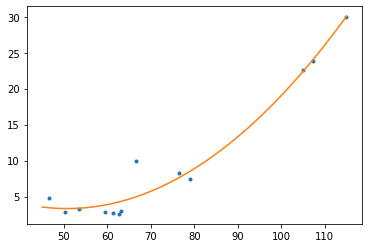

In [100]:
import matplotlib.pyplot as plt
# xp = x
_ = plt.plot(x, y, '.', xp, p(xp))

plt.show()

In [101]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df1['Wasserstein_dist'], y=df1['RMSE'], mode='markers', marker_symbol='square', marker = dict(size=10, color='red'), name='Data'))
fig.add_trace(go.Scatter(x=xp, y=p(xp), mode='lines', name='Fitted Curve', marker=dict(color='Blue')))
fig.update_layout(
    title="An illustration of fitting a curve to statistical mapping of dissimilarity and performance",
    xaxis_title="Dissimilarity (Wasserstein distance)",
    yaxis_title="Performance (RMSE)",  
    font=dict(
        family="Arial",
        size=16,
        color="Black"
    )
)
fig.show()

In [102]:
df1.to_csv('JPM_results.csv', index=False)

In [103]:
ys = 100 - acc_df2['MAPE']*100

In [104]:
x = np.array(df1['Wasserstein_dist'].values)
y = np.array(ys)
z = np.polyfit(x, y, 2)

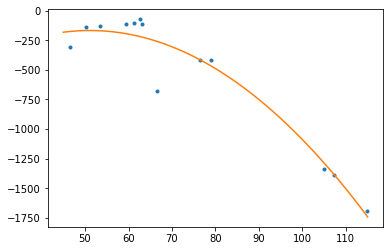

In [105]:
p = np.poly1d(z)
xp = np.linspace(45, 115, 100)
_ = plt.plot(x, y, '.', xp, p(xp))

plt.show()

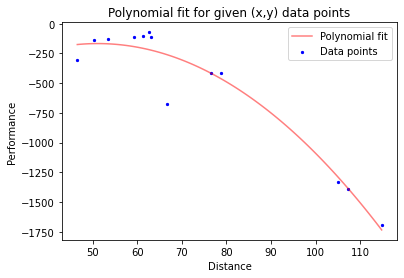

In [106]:
fit_polynomial_curve_to_data_and_visualize(x, y)

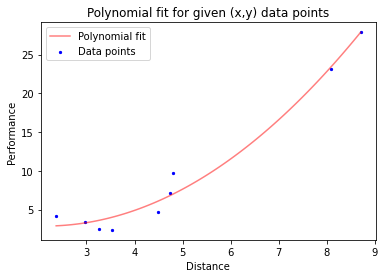

In [107]:
fit_polynomial_curve_to_data_and_visualize(df['DTS_dist'].values, df['RMSE'].values)

#### Curve fitting using Scipy's curve_fit() function

In [108]:
from scipy.optimize import curve_fit
import math

In [109]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

In [110]:
y_values = 100 - acc_df2['MAPE']
# y_values

In [111]:
xs = df1['Wasserstein_dist'].values
ys = y_values.tolist()

In [112]:
p0 = (4, .1, 0.5) # start with values near those we expect
# params, cv =  curve_fit(monoExp, xs, ys, p0)
# m, t, b = params

In [113]:
# # plot the results
# plt.plot(xs, ys, '.', label="data")
# plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")

In [114]:
fig = px.scatter(x=df['Wasserstein_dist'], y=df['R2-score'])
fig.update_traces(marker_size=10)
fig.show()

#### Timseries based similarity measures between train and test

In [115]:
def get_timeseries_distance_measures(X1, X2):
    
    DTW_distance = TSdist.DTWDistance(X1, X2)    
    Jensen_Shannon_distance = jsd(X1, X2)
    KL_Divergence = computeKLD(X1, X2, 7)

    return {'DTW_distance': "{:.2f}".format(DTW_distance.item()),            
            'Jensen_Shannon_distance':Jensen_Shannon_distance,
            'KL_Divergence': KL_Divergence
        }

In [116]:
test_set_range = []
finalResult = []

for i in range(5):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]
    distances = get_timeseries_distance_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [117]:
df2 = pd.DataFrame(finalResult)
df2.insert(0, 'Test set range', test_set_range)
df2

,Test set range,DTW_distance,Jensen_Shannon_distance,KL_Divergence
0,0 : 100,210916.54,0.012658,7056.140695
1,100 : 200,171866.07,0.014303,7050.907396
2,200 : 300,193450.28,0.012931,7520.859888
3,300 : 400,216125.27,0.015716,6591.449469
4,400 : 500,128483.64,0.016497,7042.228336
